In [28]:
%pip install pandas -q
%pip install matplotlib -q
%pip install kagglehub -q
%pip install tensorflow -q
%pip install scikit-learn -q
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [29]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, Dropout, BatchNormalization 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [30]:
# загрузим данные
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")


In [31]:
# преднастройка формаирование датасета
settings_loading_data = dict(
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale', # если использовать предобученную ч/б модель, то изменить этот параметр на 'grayscale'
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest', # Попробовать: bicubic (лучшая, но тяжёлая) lanczos3/5 (вроде норм), было nearest
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

In [32]:
# сформируем датасеты
df_train = image_dataset_from_directory(
    path + '/chest_xray/train',
    shuffle=True,
    **settings_loading_data
)

df_valid = image_dataset_from_directory(
    path + '/chest_xray/val',
    shuffle=False,
    **settings_loading_data
)

df_test = image_dataset_from_directory(
    path + '/chest_xray/test',
    shuffle=False,
    **settings_loading_data
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [33]:
# вывод 9 фотографий из датасета для примера
class_names = df_train.class_names
print("Классы:", class_names)

# for images, labels in df_train.take(1):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray') 
#         plt.title(f"Class: {class_names[int(labels[i].numpy().item())]}")
#         plt.axis("off")
#     plt.show()

Классы: ['NORMAL', 'PNEUMONIA']


In [34]:
# т.к. 16 изображений валидационной выборки - это очень мало, то объединим test с val, а потом разобьем их
df_train_full = df_train.concatenate(df_valid)
val_size = int(len(df_train_full) * 0.2)

df_valid = df_train_full.take(val_size)
df_train = df_train_full.skip(val_size)

print(f"Новый размер train (батчей): {len(df_train)}")
print(f"Новый размер valid (батчей): {len(df_valid)}")

Новый размер train (батчей): 132
Новый размер valid (батчей): 32


In [35]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1067 изображений
Класс PNEUMONIA (1): 3141 изображений


In [36]:
# настроим аугментацию
# 1. будем поворачивать фотографии, на 10 градусов в разные стороны
# 2. смещаем фотографии по вертикали и горизонатли на 10 процентов
# 3. зумим фотографии на 20 процентов
data_augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=10/360.0, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest", interpolation="bilinear")
])

In [37]:
# Функция для нормализации
def normalize_img(image, label):
    """Приводит значения пикселей к диапазону [0, 1]."""
    return tf.cast(image, tf.float32) / 255.0, label

# Функция аугментации и нормализации для ТРЕНИРОВОЧНЫХ данных
def augment_and_normalize_train(image, label):
    """Применяет аугментацию и затем нормализует изображение."""
    image_augmented = data_augmentation_pipeline(image, training=True)
    return tf.cast(image_augmented, tf.float32) / 255.0, label

# Применяем новые функции к нашим датасетам
# Важно: аугментацию применяем ТОЛЬКО к df_train
df_train_processed = df_train.map(augment_and_normalize_train, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_valid_processed = df_valid.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_test_processed = df_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [38]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train_processed:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1077 изображений
Класс PNEUMONIA (1): 3131 изображений


In [39]:
# рассчитаем class_weights
# сделаем это через кол-во элементов одного и второго класса
labels = np.concatenate([y for x, y in df_train_processed], axis=0)
normal_count = np.sum(labels == 0)
pneumonia_count = np.sum(labels == 1)
total_count = len(labels)

weight_for_0 = (1 / normal_count) * (total_count / 2)
weight_for_1 = (1 / pneumonia_count) * (total_count / 2)

class_weights = {0: weight_for_0, 1: weight_for_1}

2025-07-30 18:22:09.786192: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [40]:
# создадим модель
# tf.keras.backend.set_image_data_format('channels_last')
# backbone = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
# backbone.trainable = False

model = Sequential()
# model.add(backbone)

# --- БЛОК 1: Входной блок, ищем самые простые признаки ---
# Входное изображение: (224, 224, 3)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
# Выход: (112, 112, 32)

# --- БЛОК 2: Увеличиваем количество фильтров ---
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
# Выход: (56, 56, 64)

# --- БЛОК 3: Еще больше фильтров, добавляем Dropout ---
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2)) # Небольшой Dropout для сверточной части
# Выход: (28, 28, 128)

# --- БЛОК 4: Максимальное количество фильтров ---
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))
# Выход: (14, 14, 256)

# --- ГОЛОВА: Преобразование признаков в финальное решение ---
model.add(Flatten())

# Плотный слой для комбинации признаков
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5)) # Агрессивный Dropout для плотной части
    
    # Выходной слой
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(learning_rate=1e-3), 
    metrics=[
        'accuracy',       
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)
# history_head = model.fit(
#     df_train_processed,
#     validation_data=df_valid_processed,
#     class_weight=class_weights,
#     epochs=5
# )

/home/koziy/projects/xray_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
# backbone.trainable = True
# model.compile(
#     loss='binary_crossentropy', 
#     optimizer=Adam(learning_rate=1e-5), 
#     metrics=[
#         'accuracy',       
#         tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall'),
#         tf.keras.metrics.AUC(name='auc')
#     ]
# )

# используем коллбэки
# 1. Настройка learning rate при обучении
# 2. Сохранение лучшей версии модели
# 3. Остановка обучения, если нет улучшений
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    df_train_processed,
    validation_data=df_valid_processed,
    class_weight=class_weights,
    epochs=30,
    callbacks=[reduce_lr, model_checkpoint, early_stopping]
)

Epoch 1/30


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8122 - auc: 0.9131 - loss: 0.4637 - precision: 0.9605 - recall: 0.7804

132/132 ━━━━━━━━━━━━━━━━━━━━ 34s 163ms/step - accuracy: 0.8125 - auc: 0.9133 - loss: 0.4629 - precision: 0.9606 - recall: 0.7807 - val_accuracy: 0.7266 - val_auc: 0.5000 - val_loss: 7.1539 - val_precision: 0.7266 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/30
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9097 - auc: 0.9691 - loss: 0.2332 - precision: 0.9747 - recall: 0.9022

132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.9097 - auc: 0.9691 - loss: 0.2333 - precision: 0.9746 - recall: 0.9022 - val_accuracy: 0.7188 - val_auc: 0.5629 - val_loss: 1.2950 - val_precision: 0.7330 - val_recall: 0.9721 - learning_rate: 0.0010
Epoch 3/30
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9064 - auc: 0.9715 - loss: 0.2245 - precision: 0.9767 - recall: 0.8931

132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.9064 - auc: 0.9715 - loss: 0.2244 - precision: 0.9766 - recall: 0.8932 - val_accuracy: 0.7246 - val_auc: 0.9122 - val_loss: 1.1930 - val_precision: 0.7275 - val_recall: 0.9946 - learning_rate: 0.0010
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.9336 - auc: 0.9780 - loss: 0.1830 - precision: 0.9823 - recall: 0.9269 - val_accuracy: 0.7275 - val_auc: 0.5000 - val_loss: 4.0050 - val_precision: 0.7275 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/30
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9097 - auc: 0.9692 - loss: 0.2286 - precision: 0.9754 - recall: 0.9022
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.9097 - auc: 0.9692 - loss: 0.2288 - precision: 0.9754 - recall: 0.9023 - val_accuracy: 0.7266 - val_auc: 0.5839 - val_loss: 1.8781 - val_precision: 0.7263 - val_recall: 1.0000 - learning_rate: 0.0010


132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.9372 - auc: 0.9868 - loss: 0.1476 - precision: 0.9880 - recall: 0.9270 - val_accuracy: 0.9014 - val_auc: 0.9853 - val_loss: 0.2388 - val_precision: 0.8861 - val_recall: 0.9919 - learning_rate: 2.0000e-04
Epoch 7/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9341 - auc: 0.9846 - loss: 0.1559 - precision: 0.9873 - recall: 0.9236 - val_accuracy: 0.8691 - val_auc: 0.9771 - val_loss: 0.3486 - val_precision: 0.8504 - val_recall: 0.9946 - learning_rate: 2.0000e-04
Epoch 8/30
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9336 - auc: 0.9836 - loss: 0.1660 - precision: 0.9781 - recall: 0.9299

132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.9336 - auc: 0.9836 - loss: 0.1659 - precision: 0.9781 - recall: 0.9299 - val_accuracy: 0.9434 - val_auc: 0.9911 - val_loss: 0.1741 - val_precision: 0.9928 - val_recall: 0.9290 - learning_rate: 2.0000e-04
Epoch 9/30
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9359 - auc: 0.9830 - loss: 0.1623 - precision: 0.9858 - recall: 0.9270

132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.9359 - auc: 0.9830 - loss: 0.1622 - precision: 0.9858 - recall: 0.9271 - val_accuracy: 0.9658 - val_auc: 0.9916 - val_loss: 0.1062 - val_precision: 0.9903 - val_recall: 0.9624 - learning_rate: 2.0000e-04
Epoch 10/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9460 - auc: 0.9883 - loss: 0.1363 - precision: 0.9878 - recall: 0.9391 - val_accuracy: 0.8584 - val_auc: 0.9810 - val_loss: 0.5142 - val_precision: 0.9983 - val_recall: 0.8054 - learning_rate: 2.0000e-04
Epoch 11/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9375 - auc: 0.9835 - loss: 0.1644 - precision: 0.9774 - recall: 0.9378
Epoch 11: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.9375 - auc: 0.9835 - loss: 0.1643 - precision: 0.9774 - recall: 0.9378 - val_accuracy: 0.9648 - val_auc: 0.9902 - val_loss: 0.1102 - val_precision: 0.9822 - val_recall: 0.9690 - learning_ra

In [42]:
# проверим модель на тесте
results = model.evaluate(df_test_processed)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.7285 - auc: 0.6188 - loss: 0.9627 - precision: 0.4207 - recall: 0.6636  
Test Loss: 0.5946863889694214
Test Accuracy: 0.8381410241127014


___
    ДО class_weights:
    Test Loss: 0.6504877805709839
    Test Accuracy: 0.6089743375778198

    ПОСЛЕ class_weights:
    Test Loss: 0.6858784556388855
    Test Accuracy: 0.6330128312110901
___

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


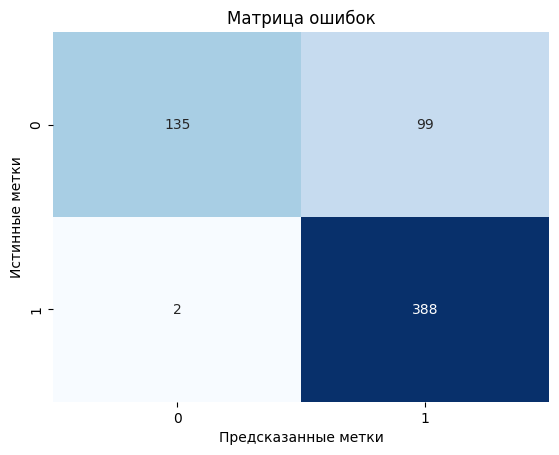

              precision    recall  f1-score   support

      NORMAL       0.99      0.58      0.73       234
   PNEUMONIA       0.80      0.99      0.88       390

    accuracy                           0.84       624
   macro avg       0.89      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624



In [43]:
# сделаем матрицу ошибок
y_pred_proba = model.predict(df_test_processed)
y_pred = (y_pred_proba > 0.5).astype('int32')
y_true = np.concatenate([y for x, y in df_test_processed], axis=0)


cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

___
  ДО class_weights:
  0 - 17 - 217
  1 - 27 - 363
    | 0  |  1 |

  ПОСЛЕ class_weights:
  0 - 11 - 223
  1 - 6 - 384
    | 0  |  1 |
___